## Description:
Train a convolutional Koopman autoencoder on structured-grid HDF5 snapshots.
A CNN encoder maps each snapshot to a latent vector, a linear operator K advances it in time, and a deconvolutional decoder reconstructs the field.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import re
import yaml
import numpy as np
import h5py

from mpi4py import MPI

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

comm = MPI.COMM_WORLD
rank = comm.rank


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "CNN_Koopman" / "CNN_Koopman.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

TIME_STEP_START = CFG.get("TIME_STEP_START", None)
TIME_STEP_END = CFG.get("TIME_STEP_END", None)
PRED_TIME_STEP_START = CFG.get("PRED_TIME_STEP_START", None)
PRED_TIME_STEP_END = CFG.get("PRED_TIME_STEP_END", None)

PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
CASE_DIR = CFG.get("CASE_DIR", None)

REPORT_BASE_DIR = PROJECT_ROOT / Path(CFG.get("REPORT_BASE_DIR", "report_figures/case_studies/CNN_Koopman"))
PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"
if TIME_STEP_START is None or TIME_STEP_END is None:
    TIME_TAG = "t_unknown"
elif TIME_STEP_START == TIME_STEP_END:
    TIME_TAG = f"t_{int(TIME_STEP_START)}"
else:
    TIME_TAG = f"t_{int(TIME_STEP_START)}_to_{int(TIME_STEP_END)}"
OUT_DIR = REPORT_BASE_DIR / PHI_TAG / LAT_TAG / TIME_TAG

def save_plot(fig, stem: str, out_dir: Path | None = None) -> None:
    pad = 0.02
    try:
        engine = fig.get_layout_engine()
    except Exception:
        engine = None
    if engine is None:
        fig.tight_layout(pad=pad)
    if out_dir is None:
        return
    out_dir.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_dir / f"{stem}.png", dpi=FIG_DPI, bbox_inches='tight', pad_inches=pad)
    fig.savefig(out_dir / f"{stem}.pdf", bbox_inches='tight', pad_inches=pad)
    fig.savefig(out_dir / f"{stem}.svg", bbox_inches='tight', pad_inches=pad)

OUTPUT_FILE_STEM = str(CFG.get("OUTPUT_FILE_STEM", "structured_fields"))
FILE_INDEX_PAD = int(CFG.get("FILE_INDEX_PAD", 5))
POINTS_FNAME = str(CFG.get("POINTS_FNAME", "points.hdf5"))

FIELD_NAME = str(CFG["FIELD_NAME"])
USE_TIME_ATTR = bool(CFG.get("USE_TIME_ATTR", True))

if CASE_DIR:
    case_dir = PROJECT_ROOT / Path(CASE_DIR)
else:
    phi_tag = f"phi_{PHI:.2f}"
    lat_tag = f"h400x{LAT_SIZE}_ref"
    case_dir = BASE_DIR / phi_tag / lat_tag

points_path = case_dir / POINTS_FNAME
coords_path = case_dir / f"coordinates_{OUTPUT_FILE_STEM}.hdf5"
GRID_SHAPE = None

if rank == 0:
    print(f"Case dir: {case_dir}")

def _file_index(path: Path) -> int:
    m = re.search(r"(\d+)$", path.stem)
    return int(m.group(1)) if m else 0

def _file_time(path: Path) -> float:
    if USE_TIME_ATTR:
        try:
            with h5py.File(path, "r") as f:
                t = f.attrs.get("time", None)
            if t is not None:
                return float(t)
        except OSError:
            pass
    return float(_file_index(path))

def _build_files(step_start, step_end):
    if step_start is None or step_end is None:
        return None
    s0 = int(step_start)
    s1 = int(step_end)
    steps = list(range(s0, s1 + 1))
    out = [
        case_dir / f"{OUTPUT_FILE_STEM}{str(ts).zfill(FILE_INDEX_PAD)}.hdf5"
        for ts in steps
    ]
    return [p for p in out if p.exists()]

train_files = _build_files(TIME_STEP_START, TIME_STEP_END)
if train_files is None:
    train_files = sorted(case_dir.glob(f"{OUTPUT_FILE_STEM}*.hdf5"))

if not train_files:
    raise FileNotFoundError(f"No HDF5 files found in {case_dir}")

train_info = [(_file_time(p), p) for p in train_files]
train_info.sort(key=lambda x: x[0])
times = [t for t, _ in train_info]
files = [p for _, p in train_info]

pred_files = []
pred_times = []
if PRED_TIME_STEP_START is not None and PRED_TIME_STEP_END is not None:
    pred_files = _build_files(PRED_TIME_STEP_START, PRED_TIME_STEP_END)
    if not pred_files:
        raise FileNotFoundError(f"No prediction HDF5 files found in {case_dir}")
    pred_info = [(_file_time(p), p) for p in pred_files]
    pred_info.sort(key=lambda x: x[0])
    pred_times = [t for t, _ in pred_info]
    pred_files = [p for _, p in pred_info]

if rank == 0:
    print(f"Training files: {len(files)}. time range: {times[0]} -> {times[-1]}")
    if pred_files:
        print(f"Prediction files: {len(pred_files)}. time range: {pred_times[0]} -> {pred_times[-1]}")
    print(f"Field: {FIELD_NAME}")

def _read_field(path: Path, field_name: str) -> np.ndarray:
    with h5py.File(path, "r") as f:
        if field_name not in f:
            raise KeyError(
                f"Field '{field_name}' not found in {path.name}."
            )
        data = f[field_name][:]
    return data

def _load_grid_shape() -> tuple[int, ...] | None:
    global GRID_SHAPE
    if GRID_SHAPE is not None:
        return GRID_SHAPE
    for cand in (points_path, coords_path):
        if cand is None:
            continue
        if not Path(cand).exists():
            continue
        try:
            with h5py.File(cand, "r") as f:
                for key in ("x", "y", "z"):
                    if key in f:
                        GRID_SHAPE = f[key].shape
                        return GRID_SHAPE
        except OSError:
            continue
    return None

def _to_channels(arr: np.ndarray) -> tuple[np.ndarray, tuple[int, ...]]:
    if arr.ndim == 1:
        grid_shape = _load_grid_shape()
        if grid_shape is None:
            raise ValueError(
                "Field is 1D; could not infer grid shape. Provide points.hdf5 or coordinates_*.hdf5."
            )
        if arr.size != int(np.prod(grid_shape)):
            raise ValueError(
                f"Field size {arr.size} does not match grid size {int(np.prod(grid_shape))}."
            )
        arr = arr.reshape(grid_shape)
    if arr.ndim == 2:
        return arr[None, ...], arr.shape
    if arr.ndim == 3:
        return np.transpose(arr, (2, 0, 1)), arr.shape
    raise ValueError(f"Unsupported field ndim={arr.ndim}.")

fields = []
field_shape = None
channel_shape = None
for p in files:
    data = _read_field(p, FIELD_NAME)
    ch, shape = _to_channels(data)
    if field_shape is None:
        field_shape = shape
        channel_shape = ch.shape
    else:
        if shape != field_shape:
            raise ValueError(
                f"Field shape mismatch: {shape} vs {field_shape} at {p.name}"
            )
        if ch.shape != channel_shape:
            raise ValueError(
                f"Channel shape mismatch: {ch.shape} vs {channel_shape} at {p.name}"
            )
    fields.append(ch)

X = np.stack(fields, axis=0).astype(np.float32)
T, C, H, W = X.shape

X_pred = None
T_pred = 0
if pred_files:
    pred_fields = []
    for p in pred_files:
        data = _read_field(p, FIELD_NAME)
        ch, shape = _to_channels(data)
        if shape != field_shape:
            raise ValueError(
                f"Prediction field shape mismatch: {shape} vs {field_shape} at {p.name}"
            )
        if ch.shape != channel_shape:
            raise ValueError(
                f"Prediction channel shape mismatch: {ch.shape} vs {channel_shape} at {p.name}"
            )
        pred_fields.append(ch)
    X_pred = np.stack(pred_fields, axis=0).astype(np.float32)
    T_pred = X_pred.shape[0]

if rank == 0:
    print(f"Loaded X (train): T={T}, C={C}, H={H}, W={W}")
    if pred_files:
        print(f"Loaded X_pred: T={T_pred}, C={C}, H={H}, W={W}")


Case dir: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/structured_grids/phi_0.40/h400x025_ref
Training files: 71. time range: 220.0 -> 290.0
Prediction files: 10. time range: 291.0 -> 300.0
Field: t
Loaded X (train): T=71, C=1, H=800, W=200
Loaded X_pred: T=10, C=1, H=800, W=200


In [3]:
# ============================================================
# PLOT STYLE (template-based)
# ============================================================
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"






LINE_WIDTH = 2.2


def style_colorbar(cbar, *, nbins: int = 5) -> None:
    from matplotlib.ticker import MaxNLocator
    cbar.ax.tick_params(labelsize=PLOT_FONT_SIZE - 6)
    cbar.locator = MaxNLocator(nbins=nbins)
    cbar.update_ticks()


def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True, pad=10)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.xaxis.labelpad = 10
    ax.yaxis.labelpad = 10
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

def _fix_tricontourf(cf):
    """Remove edge seams in vector outputs."""
    if hasattr(cf, "set_rasterized"):
        cf.set_rasterized(True)
    collections = getattr(cf, "collections", None)
    if collections is None:
        collections = getattr(cf, "artists", None)
    if collections is None:
        try:
            collections = cf.get_children()
        except Exception:
            collections = []
    for coll in collections:
        if hasattr(coll, "set_edgecolor"):
            coll.set_edgecolor("none")
        if hasattr(coll, "set_linewidth"):
            coll.set_linewidth(0.0)
        if hasattr(coll, "set_antialiased"):
            coll.set_antialiased(False)


def annotate_no_overlap(
    ax,
    xs,
    ys,
    labels,
    *,
    min_sep=0.025,
    fontsize=None,
    fontweight=None,
) -> None:
    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)

    if xs.size == 0:
        return

    x_span = float(np.ptp(xs)) or 1.0
    y_span = float(np.ptp(ys)) or 1.0

    offsets = [
        (0.01, 0.01),
        (0.01, -0.01),
        (-0.01, 0.01),
        (-0.01, -0.01),
        (0.02, 0.0),
        (-0.02, 0.0),
        (0.0, 0.02),
        (0.0, -0.02),
        (0.03, 0.03),
        (0.03, -0.03),
        (-0.03, 0.03),
        (-0.03, -0.03),
    ]

    placed = []
    for x, y, label in zip(xs, ys, labels):
        best = None
        for ox, oy in offsets:
            tx = x + ox * x_span
            ty = y + oy * y_span
            if all((abs(tx - px) > min_sep * x_span) or (abs(ty - py) > min_sep * y_span) for px, py in placed):
                best = (tx, ty)
                break
        if best is None:
            best = (x + 0.04 * x_span, y + 0.04 * y_span)
        ax.text(
            best[0],
            best[1],
            str(label),
            fontsize=fontsize or (PLOT_FONT_SIZE - 8),
            fontweight=fontweight,
            ha="left",
            va="bottom",
        )
        placed.append(best)


In [4]:
DEVICE = str(CFG.get("DEVICE", "cpu"))
REMOVE_MEAN = bool(CFG.get("REMOVE_MEAN", True))
EPS = float(CFG.get("EPS", 1.0e-6))

Z_DIM = int(CFG.get("Z_DIM", 16))
ENC_CHANNELS = tuple(CFG.get("ENC_CHANNELS", [32, 64, 128]))
DEC_CHANNELS_RAW = CFG.get("DEC_CHANNELS", None)
DEC_CHANNELS = tuple(DEC_CHANNELS_RAW) if DEC_CHANNELS_RAW else tuple()
KERNEL_SIZE = int(CFG.get("KERNEL_SIZE", 3))
POOL_SIZE = int(CFG.get("POOL_SIZE", 4))
DECONV_KERNEL_SIZE = int(CFG.get("DECONV_KERNEL_SIZE", 4))
DROPOUT = float(CFG.get("DROPOUT", 0.0))

EPOCHS = int(CFG.get("EPOCHS", 500))
BATCHES_PER_EPOCH = int(CFG.get("BATCHES_PER_EPOCH", 50))
BATCH_SIZE = int(CFG.get("BATCH_SIZE", 4))
ROLLOUT_LEN = int(CFG.get("ROLLOUT_LEN", 5))

LR = float(CFG.get("LR", 1.0e-3))
WEIGHT_DECAY = float(CFG.get("WEIGHT_DECAY", 1.0e-6))

W_RECON = float(CFG.get("W_RECON", 1.0))
W_PRED = float(CFG.get("W_PRED", 1.0))
W_LAT = float(CFG.get("W_LAT", 0.1))
W_STAB = float(CFG.get("W_STAB", 0.0))

LOG_EVERY = int(CFG.get("LOG_EVERY", 50))
SEED = int(CFG.get("SEED", 0))
LOAD_CHECKPOINT = str(CFG.get("LOAD_CHECKPOINT", ""))
print(LOAD_CHECKPOINT)
np.random.seed(SEED)
torch.manual_seed(SEED)

if DEVICE == "cuda" and not torch.cuda.is_available():
    DEVICE = "cpu"
device = torch.device(DEVICE)

if rank == 0:
    print("Using device:", device)
    if device.type == "cuda":
        print("GPU:", torch.cuda.get_device_name(0))

if ROLLOUT_LEN >= T:
    raise ValueError(f"ROLLOUT_LEN={ROLLOUT_LEN} must be < number of snapshots T={T}.")

# Normalize across time and spatial dims, per channel
if REMOVE_MEAN:
    X_mean = X.mean(axis=(0, 2, 3), keepdims=True)
else:
    X_mean = np.zeros((1, C, 1, 1), dtype=X.dtype)
X_std = X.std(axis=(0, 2, 3), keepdims=True) + EPS
Xn = (X - X_mean) / X_std

Xn_torch = torch.from_numpy(Xn)


False
Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [5]:
if not ENC_CHANNELS:
    raise ValueError("ENC_CHANNELS must be non-empty.")

if DEC_CHANNELS:
    dec_channels = DEC_CHANNELS
else:
    dec_channels = tuple(reversed(ENC_CHANNELS[:-1]))


def spectral_radius(K: torch.Tensor) -> torch.Tensor:
    eigvals = torch.linalg.eigvals(K)
    return torch.max(torch.abs(eigvals)).real


def sample_batch_indices(T_total: int, rollout_len: int, batch_size: int) -> list[int]:
    max_start = T_total - (rollout_len + 1)
    if max_start < 0:
        raise ValueError(f"Not enough snapshots: T={T_total}, rollout_len={rollout_len}")
    return np.random.randint(0, max_start + 1, size=batch_size).tolist()


def make_batch(X_seq: torch.Tensor, idx0: list[int], rollout_len: int) -> torch.Tensor:
    seqs = [X_seq[i : i + rollout_len + 1] for i in idx0]
    return torch.stack(seqs, dim=0)  # (B, L+1, C, H, W)


class KoopmanCNN(nn.Module):
    """
    Convolutional autoencoder + linear latent dynamics:
      z_{k+1} = z_k K^T
    """
    def __init__(
        self,
        in_channels: int,
        enc_channels: tuple[int, ...],
        dec_channels: tuple[int, ...],
        z_dim: int,
        kernel_size: int,
        deconv_kernel: int,
        dropout: float,
        in_hw: tuple[int, int],
    ) -> None:
        super().__init__()
        pad = kernel_size // 2
        enc_layers: list[nn.Module] = []
        prev = in_channels
        for i, ch in enumerate(enc_channels):
            stride = 2 if i > 0 else 1
            enc_layers.append(nn.Conv2d(prev, ch, kernel_size, stride=stride, padding=pad))
            enc_layers.append(nn.ReLU())
            if dropout > 0.0:
                enc_layers.append(nn.Dropout2d(p=dropout))
            prev = ch
        self.enc_conv = nn.Sequential(*enc_layers)

        enc_h, enc_w = in_hw
        for i in range(1, len(enc_channels)):
            enc_h = (enc_h + 2 * pad - (kernel_size - 1) - 1) // 2 + 1
            enc_w = (enc_w + 2 * pad - (kernel_size - 1) - 1) // 2 + 1
        self.enc_hw = (enc_h, enc_w)
        self.enc_fc = nn.Linear(prev * enc_h * enc_w, z_dim)

        self.dec_fc = nn.Linear(z_dim, prev * enc_h * enc_w)
        dec_layers: list[nn.Module] = []
        dec_prev = prev
        deconv_pad = max(0, deconv_kernel // 2 - 1)
        for ch in dec_channels:
            dec_layers.append(
                nn.ConvTranspose2d(dec_prev, ch, deconv_kernel, stride=2, padding=deconv_pad)
            )
            dec_layers.append(nn.ReLU())
            if dropout > 0.0:
                dec_layers.append(nn.Dropout2d(p=dropout))
            dec_prev = ch
        dec_layers.append(nn.Conv2d(dec_prev, in_channels, kernel_size, padding=pad))
        self.dec_deconv = nn.Sequential(*dec_layers)

        self.enc_out_channels = prev

        self.K = nn.Parameter(torch.eye(z_dim))

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        h = self.enc_conv(x)
        h = h.flatten(1)
        return self.enc_fc(h)

    def decode(self, z: torch.Tensor, out_hw: tuple[int, int]) -> torch.Tensor:
        B = z.shape[0]
        h = self.dec_fc(z).view(B, self.enc_out_channels, self.enc_hw[0], self.enc_hw[1])
        y = self.dec_deconv(h)
        if y.shape[-2:] != out_hw:
            y = F.interpolate(y, size=out_hw, mode="bilinear", align_corners=False)
        return y

    def step_latent(self, z: torch.Tensor) -> torch.Tensor:
        return z @ self.K.T


model = KoopmanCNN(
    in_channels=C,
    enc_channels=ENC_CHANNELS,
    dec_channels=dec_channels,
    z_dim=Z_DIM,
    kernel_size=KERNEL_SIZE,
    deconv_kernel=DECONV_KERNEL_SIZE,
    dropout=DROPOUT,
    in_hw=(H, W),
).to(device)


opt = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
mse = nn.MSELoss()

if rank == 0:
    print(
        f"Training KoopmanCNN: z_dim={Z_DIM}, T={T}, rollout_len={ROLLOUT_LEN}, grid=({H},{W})"
    )

if False:
    chkpt_path = PROJECT_ROOT / "data" / "checkpoints" / "cnn_koopman.pt"
    ckpt = torch.load(chkpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    opt.load_state_dict(ckpt["opt_state"])
    start_epoch = int(ckpt.get("epoch", 0)) + 1
else: 
    start_epoch = 1  

for epoch in range(start_epoch, EPOCHS + 1):
    model.train()
    losses = []

    for _ in range(BATCHES_PER_EPOCH):
        idx0 = sample_batch_indices(T, ROLLOUT_LEN, batch_size=BATCH_SIZE)
        Xb = make_batch(Xn_torch, idx0, ROLLOUT_LEN).to(device)  # (B, L+1, C, H, W)
        B, Lp1, _, Hb, Wb = Xb.shape
        L = Lp1 - 1

        Xflat = Xb.reshape(B * (L + 1), C, Hb, Wb)
        z_true = model.encode(Xflat).reshape(B, L + 1, Z_DIM)

        X_recon = model.decode(
            z_true.reshape(B * (L + 1), Z_DIM),
            out_hw=(Hb, Wb),
        ).reshape(B, L + 1, C, Hb, Wb)
        loss_recon = mse(X_recon, Xb)

        z_list = [z_true[:, 0, :]]
        for _k in range(L):
            z_list.append(model.step_latent(z_list[-1]))
        z_pred = torch.stack(z_list, dim=1)  # (B, L+1, Z_DIM)

        X_pred_rollout = model.decode(
            z_pred.reshape(B * (L + 1), Z_DIM),
            out_hw=(Hb, Wb),
        ).reshape(B, L + 1, C, Hb, Wb)

        loss_pred = mse(X_pred_rollout[:, 1:, ...], Xb[:, 1:, ...])
        loss_lat = mse(z_pred[:, 1:, :], z_true[:, 1:, :])

        rho = spectral_radius(model.K)
        loss_stab = torch.relu(rho - 1.0) ** 2

        loss = W_RECON * loss_recon + W_PRED * loss_pred + W_LAT * loss_lat + W_STAB * loss_stab

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        losses.append(loss.item())

    if device.type == "cuda":
        torch.cuda.empty_cache()

    if rank == 0 and (epoch == start_epoch or epoch % LOG_EVERY == 0):
        avg = float(np.mean(losses)) if losses else float("nan")
        with torch.no_grad():
            rho_val = float(spectral_radius(model.K).cpu().item())
        print(f"Epoch {epoch:5d}/{EPOCHS} | loss={avg:.6e} | rho(K)={rho_val:.6f}")


Training KoopmanCNN: z_dim=64, T=71, rollout_len=5, grid=(800,200)


OutOfMemoryError: CUDA out of memory. Tried to allocate 470.00 MiB. GPU 0 has a total capacity of 3.68 GiB of which 49.62 MiB is free. Including non-PyTorch memory, this process has 3.61 GiB memory in use. Of the allocated memory 3.07 GiB is allocated by PyTorch, and 446.63 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [6]:
ckpt_path = PROJECT_ROOT / "data" / "checkpoints" / "cnn_koopman.pt"
ckpt_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(
    {
        "model_state": model.state_dict(),
        "opt_state": opt.state_dict(),
        "epoch": epoch,  # last completed epoch if you're inside the loop
        "cfg": CFG,
    },
    ckpt_path,
)
print("Saved:", ckpt_path)


Saved: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/checkpoints/cnn_koopman.pt


One-step eval at index 90: RMSE=1.458664e-01, R2=9.940149e-01
Wrote prediction: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/fields/koopman_cnn_predictions/koopman_cnn_pred_t_t291.0.hdf5
Forecast compare at t=291.0: RMSE=1.858467e-01, R2=9.903014e-01


/tmp/ipykernel_54514/945360659.py:134: UserWarning: linewidths is ignored by contourf
  cf_true = ax_true.tricontourf(tri_true, true_slice.ravel(), levels=pred_true_levels, vmin=joint_min, vmax=joint_max, cmap=plt.cm.viridis, antialiased=False, linewidths=0)
/tmp/ipykernel_54514/2225155395.py:85: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x7e6e81e2b200>' will be ignored
  cf.set_rasterized(True)


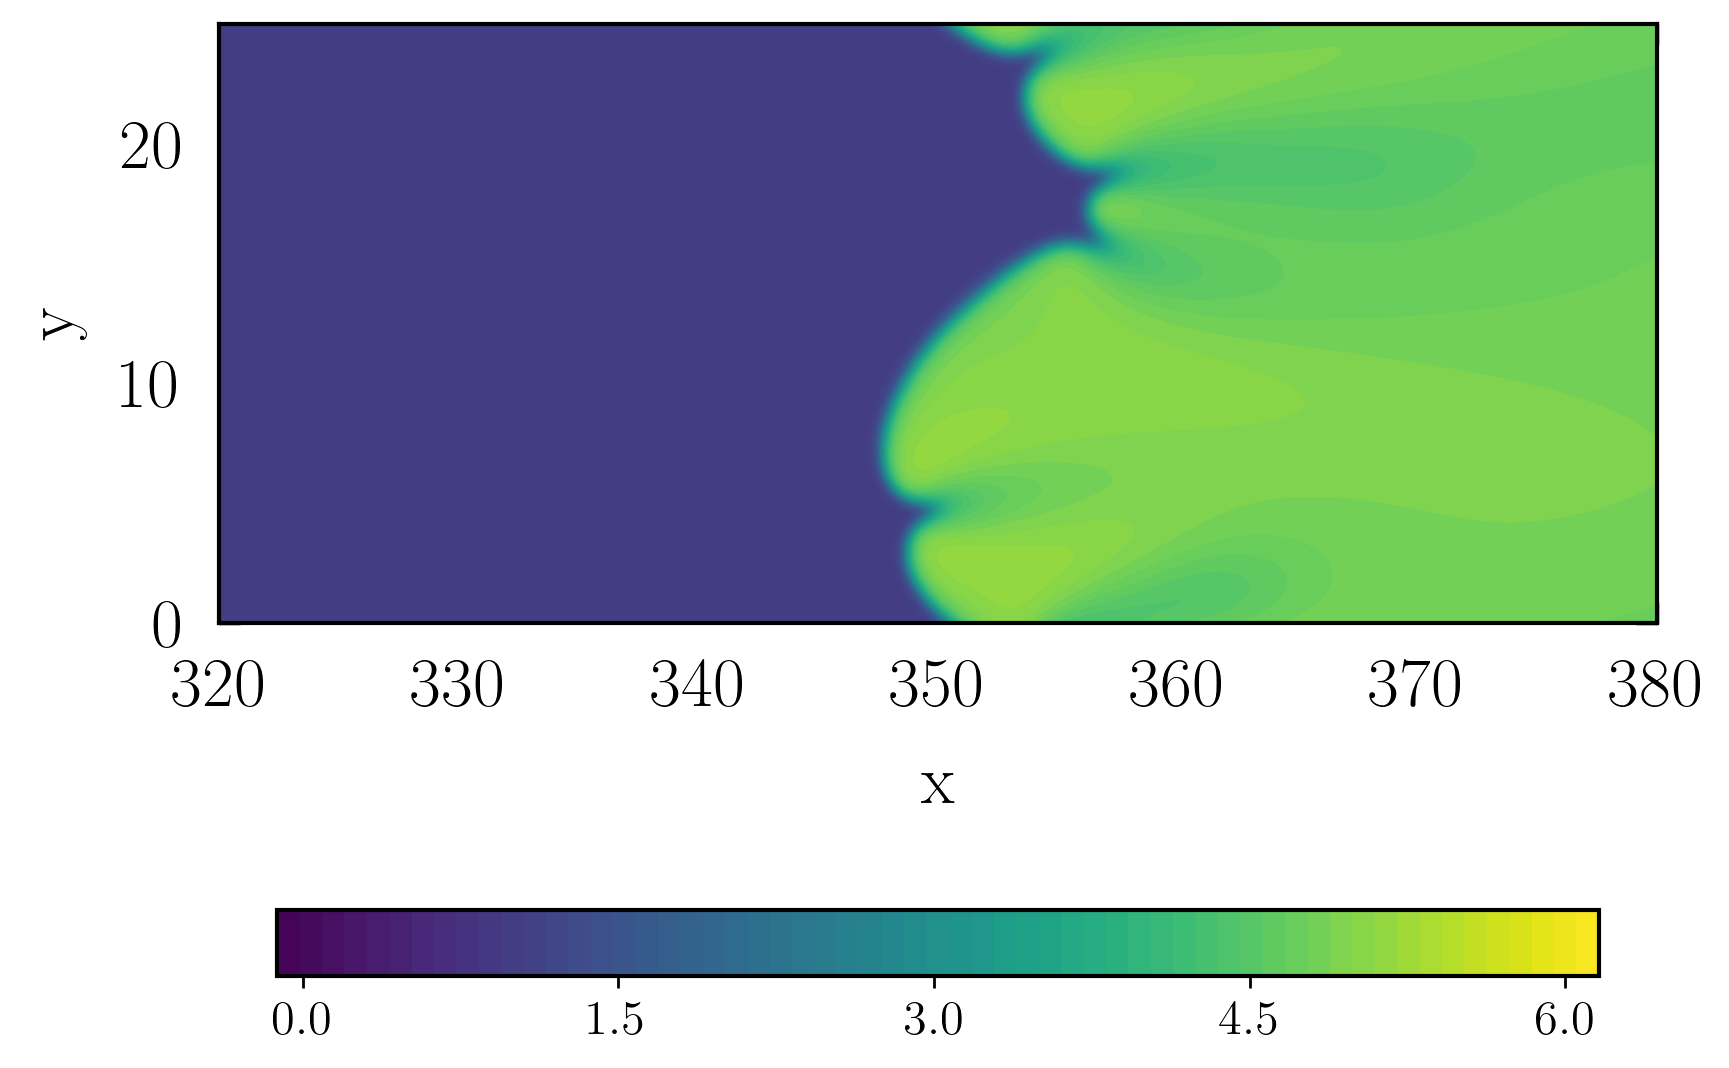

/tmp/ipykernel_54514/945360659.py:158: UserWarning: linewidths is ignored by contourf
  cf_pred = ax_pred.tricontourf(tri_pred, pred_slice.ravel(), levels=pred_true_levels, vmin=joint_min, vmax=joint_max, cmap=plt.cm.viridis, antialiased=False, linewidths=0)
/tmp/ipykernel_54514/2225155395.py:85: UserWarning: Rasterization of '<matplotlib.tri._tricontour.TriContourSet object at 0x7e6e80493bc0>' will be ignored
  cf.set_rasterized(True)


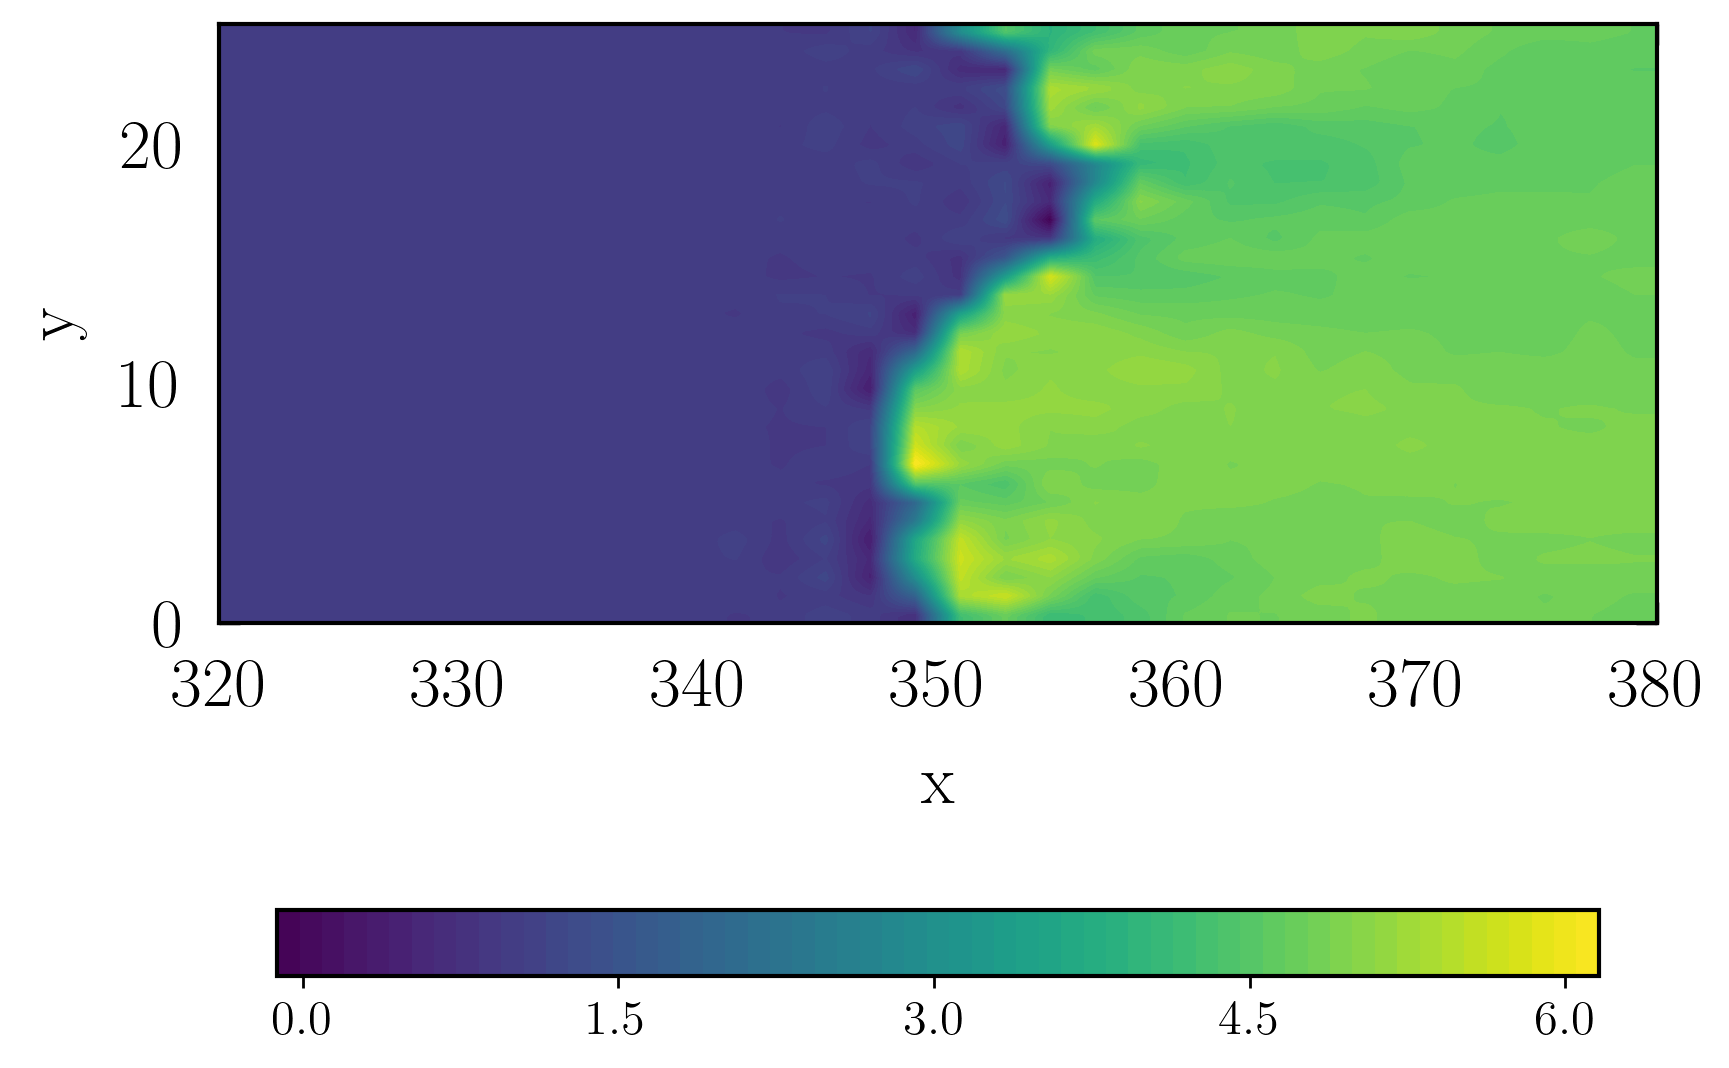

In [7]:
def _from_channels(arr: np.ndarray, shape: tuple[int, ...]) -> np.ndarray:
    if len(shape) == 2:
        return arr[0]
    if len(shape) == 3:
        return np.transpose(arr, (1, 2, 0))
    raise ValueError(f"Unsupported output shape: {shape}")

if T < 2:
    raise ValueError("Need at least 2 snapshots for one-step evaluation.")

eval_idx = T - 2
model.eval()
with torch.no_grad():
    x_eval = torch.from_numpy(Xn[eval_idx]).unsqueeze(0).to(device)
    z_eval = model.encode(x_eval)
    z_eval_next = model.step_latent(z_eval)
    pred_eval = model.decode(z_eval_next, out_hw=(H, W))[0].cpu().numpy()

pred_eval_denorm = pred_eval * X_std.squeeze(0) + X_mean.squeeze(0)
true_eval = X[eval_idx + 1]

err = pred_eval_denorm - true_eval
rmse = float(np.sqrt(np.mean(err ** 2)))
ss_res = float(np.sum(err ** 2))
ss_tot = float(np.sum((true_eval - true_eval.mean()) ** 2))
r2 = 1.0 - ss_res / (ss_tot + 1.0e-12)

if rank == 0:
    print(
        f"One-step eval at index {eval_idx + 1}: RMSE={rmse:.6e}, R2={r2:.6e}"
    )

# Forecast next timestep from the last snapshot
with torch.no_grad():
    x_last = torch.from_numpy(Xn[-1]).unsqueeze(0).to(device)
    z_last = model.encode(x_last)
    z_next = model.step_latent(z_last)
    pred_next = model.decode(z_next, out_hw=(H, W))[0].cpu().numpy()

pred_next_denorm = pred_next * X_std.squeeze(0) + X_mean.squeeze(0)
pred_field = _from_channels(pred_next_denorm, field_shape)

if T >= 2:
    dt = times[-1] - times[-2]
else:
    dt = 1.0
t_next = times[-1] + dt

PRED_OUT_DIR = PROJECT_ROOT / Path(CFG.get("PRED_OUT_DIR", "data/fields/koopman_cnn_predictions"))
PRED_OUT_DIR.mkdir(parents=True, exist_ok=True)

out_path = PRED_OUT_DIR / f"koopman_cnn_pred_{FIELD_NAME}_t{t_next}.hdf5"

if rank == 0:
    with h5py.File(out_path, "w") as f:
        f.attrs["time"] = float(t_next)
        f.create_dataset(FIELD_NAME, data=pred_field)
    print(f"Wrote prediction: {out_path}")

# Optional: compare to true next-step if available in pred_files
if pred_files:
    def _find_time_index(time_list: list[float], target: float, tol: float = 1.0e-8):
        for i, t in enumerate(time_list):
            if abs(t - target) <= tol:
                return i
        return None

    idx = _find_time_index(pred_times, float(t_next))
    if idx is not None:
        true_next = X_pred[idx]
        if torch.is_tensor(true_next):
            true_next = true_next.detach().cpu().numpy()
        err_next = pred_next_denorm - true_next
        rmse_next = float(np.sqrt(np.mean(err_next ** 2)))
        ss_res_next = float(np.sum(err_next ** 2))
        ss_tot_next = float(np.sum((true_next - true_next.mean()) ** 2))
        r2_next = 1.0 - ss_res_next / (ss_tot_next + 1.0e-12)
        if rank == 0:
            print(
                f"Forecast compare at t={t_next}: RMSE={rmse_next:.6e}, R2={r2_next:.6e}"
            )

# Quick plot (in-sample one-step)
PLOT_OUT_DIR = OUT_DIR / "plots"
if rank == 0:
    import matplotlib.pyplot as plt
    import matplotlib.tri as mtri

    plot_slice = CFG.get("PLOT_SLICE_INDEX", None)
    pred_plot = _from_channels(pred_eval_denorm, field_shape)
    true_plot = _from_channels(true_eval, field_shape)
    
    x_plot = None
    y_plot = None
    if 'points_path' in globals() and Path(points_path).exists():
        with h5py.File(points_path, "r") as f:
            x = f["x"][:]
            y = f["y"][:]
            z = f["z"][:]
    else:
        x = y = z = None

    if pred_plot.ndim == 2:
        pred_slice = pred_plot
        true_slice = true_plot
        if x is not None and x.ndim == 3:
            x_plot = x[:, :, 0]
            y_plot = y[:, :, 0]
        slice_label = ""
    elif pred_plot.ndim == 3:
        z_idx = int(plot_slice) if plot_slice is not None else pred_plot.shape[2] // 2
        z_idx = max(0, min(pred_plot.shape[2] - 1, z_idx))
        pred_slice = pred_plot[:, :, z_idx]
        true_slice = true_plot[:, :, z_idx]
        if x is not None and x.ndim == 3:
            x_plot = x[:, :, z_idx]
            y_plot = y[:, :, z_idx]
        slice_label = f" (z index {z_idx})"
    else:
        raise ValueError(f"Unsupported field ndim={pred_plot.ndim}")

    fig_true, ax_true = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    if x_plot is None or y_plot is None:
        xx, yy = np.meshgrid(
            np.arange(true_slice.shape[1], dtype=float),
            np.arange(true_slice.shape[0], dtype=float),
        )
    else:
        xx, yy = x_plot, y_plot
    tri_true = mtri.Triangulation(xx.ravel(), yy.ravel())
    joint_min = float(min(true_slice.min(), pred_slice.min()))
    joint_max = float(max(true_slice.max(), pred_slice.max()))
    pred_true_levels = np.linspace(joint_min, joint_max, 60)
    cf_true = ax_true.tricontourf(tri_true, true_slice.ravel(), levels=pred_true_levels, vmin=joint_min, vmax=joint_max, cmap=plt.cm.viridis, antialiased=False, linewidths=0)
    _fix_tricontourf(cf_true)
    _fix_tricontourf(cf_true)
    ax_true.set_xlabel("x")
    ax_true.set_ylabel("y")
    style_axes(ax_true, equal=True)
    cbar_true = fig_true.colorbar(cf_true, ax=ax_true, orientation="horizontal", pad=0.08, fraction=0.06)
    style_colorbar(cbar_true)
    slice_tag = ""
    if pred_plot.ndim == 3:
        slice_tag = f"_z{z_idx}"
    t_eval = times[eval_idx + 1]
    save_plot(fig_true, f"koopman_cnn_true_{FIELD_NAME}_t{t_eval}{slice_tag}", PLOT_OUT_DIR)
    plt.show()

    fig_pred, ax_pred = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    if x_plot is None or y_plot is None:
        xx, yy = np.meshgrid(
            np.arange(pred_slice.shape[1], dtype=float),
            np.arange(pred_slice.shape[0], dtype=float),
        )
    else:
        xx, yy = x_plot, y_plot
    tri_pred = mtri.Triangulation(xx.ravel(), yy.ravel())
    cf_pred = ax_pred.tricontourf(tri_pred, pred_slice.ravel(), levels=pred_true_levels, vmin=joint_min, vmax=joint_max, cmap=plt.cm.viridis, antialiased=False, linewidths=0)
    _fix_tricontourf(cf_pred)
    _fix_tricontourf(cf_pred)
    ax_pred.set_xlabel("x")
    ax_pred.set_ylabel("y")
    style_axes(ax_pred, equal=True)
    cbar_pred = fig_pred.colorbar(cf_pred, ax=ax_pred, orientation="horizontal", pad=0.08, fraction=0.06)
    style_colorbar(cbar_pred)
    t_eval = times[eval_idx + 1]
    save_plot(fig_pred, f"koopman_cnn_pred_{FIELD_NAME}_t{t_eval}{slice_tag}", PLOT_OUT_DIR)
    plt.show()


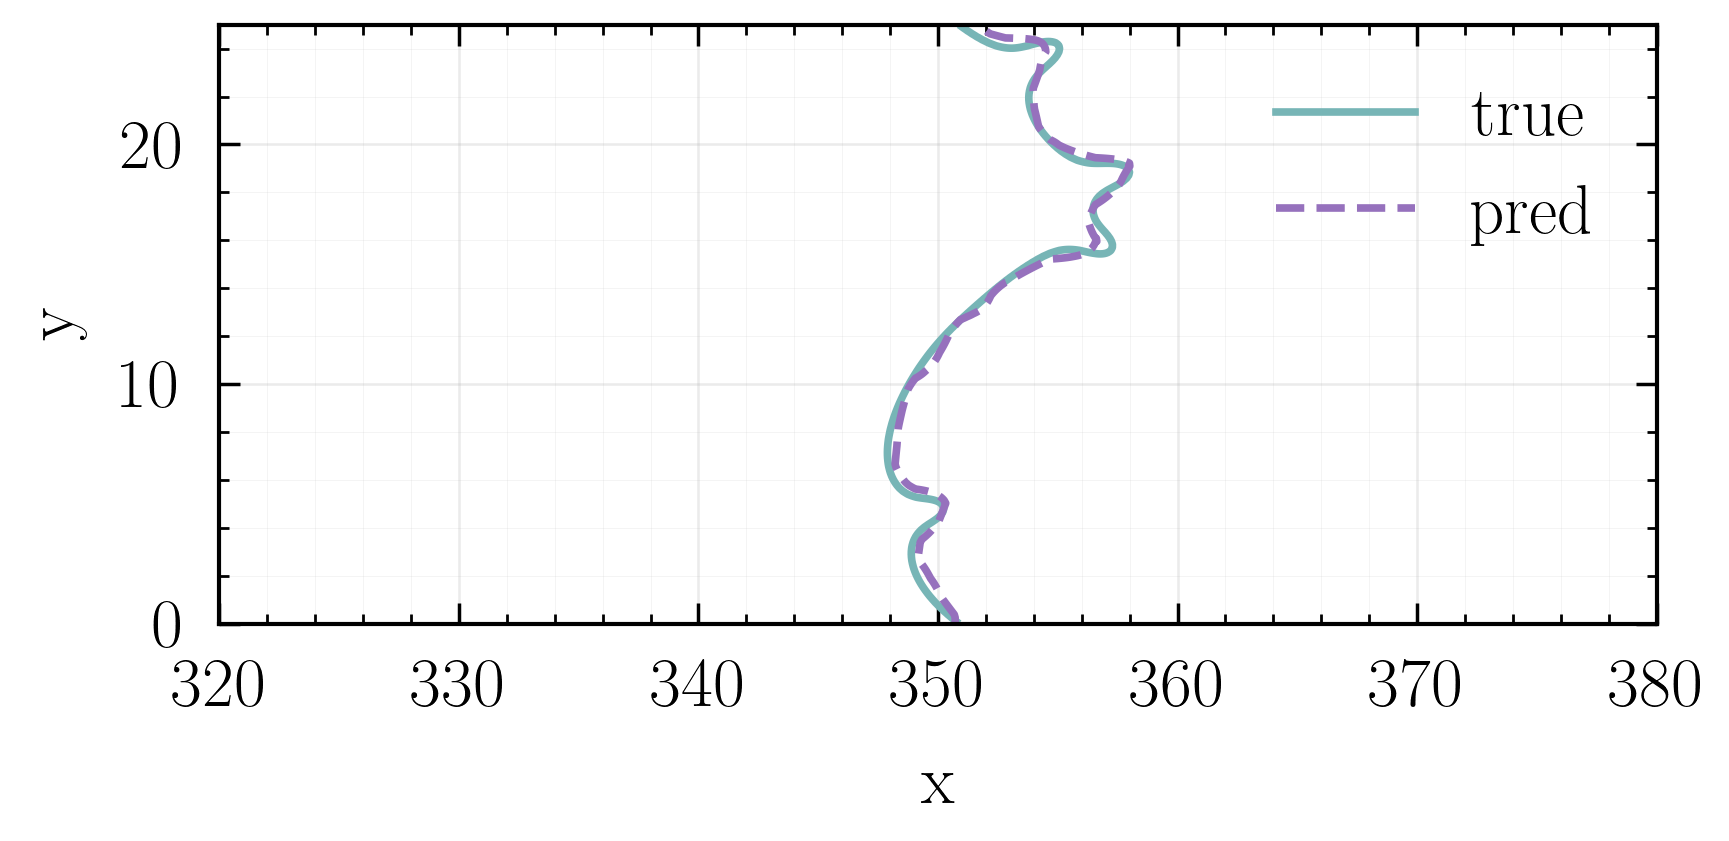

In [8]:
# --- Isocontour comparison (pred vs true) ---
if rank == 0:
    import matplotlib.pyplot as plt
    ISO_VALUE = CFG.get("ISO_VALUE", None)
    if ISO_VALUE is None:
        raise ValueError("Set ISO_VALUE in the YAML to plot isocontours.")
    ISO_VALUE = float(ISO_VALUE)

    plot_slice = CFG.get("PLOT_SLICE_INDEX", None)
    pred_plot = _from_channels(pred_eval_denorm, field_shape)
    true_plot = _from_channels(true_eval, field_shape)

    x_plot = None
    y_plot = None
    if 'points_path' in globals() and Path(points_path).exists():
        with h5py.File(points_path, "r") as f:
            x = f["x"][:]
            y = f["y"][:]
            z = f["z"][:]
    else:
        x = y = z = None

    if pred_plot.ndim == 2:
        pred_slice = pred_plot
        true_slice = true_plot
        if x is not None and x.ndim == 3:
            x_plot = x[:, :, 0]
            y_plot = y[:, :, 0]
        slice_tag = ""
    elif pred_plot.ndim == 3:
        z_idx = int(plot_slice) if plot_slice is not None else pred_plot.shape[2] // 2
        z_idx = max(0, min(pred_plot.shape[2] - 1, z_idx))
        pred_slice = pred_plot[:, :, z_idx]
        true_slice = true_plot[:, :, z_idx]
        if x is not None and x.ndim == 3:
            x_plot = x[:, :, z_idx]
            y_plot = y[:, :, z_idx]
        slice_tag = f"_z{z_idx}"
    else:
        raise ValueError(f"Unsupported field ndim={pred_plot.ndim}")

    if x_plot is None or y_plot is None:
        xx, yy = np.meshgrid(
            np.arange(pred_slice.shape[1], dtype=float),
            np.arange(pred_slice.shape[0], dtype=float),
        )
    else:
        xx, yy = x_plot, y_plot

    fig_iso, ax_iso = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax_iso.contour(xx, yy, true_slice, levels=[ISO_VALUE], colors=COLOR_DATA, linewidths=LINE_WIDTH)
    ax_iso.contour(xx, yy, pred_slice, levels=[ISO_VALUE], colors=COLOR_PRED, linewidths=LINE_WIDTH, linestyles="--")
    ax_iso.set_xlabel("x")
    ax_iso.set_ylabel("y")
    style_axes(ax_iso, equal=True)

    from matplotlib.lines import Line2D
    legend_items = [
        Line2D([0], [0], color=COLOR_DATA, lw=LINE_WIDTH, label="true"),
        Line2D([0], [0], color=COLOR_PRED, lw=LINE_WIDTH, linestyle="--", label="pred"),
    ]
    ax_iso.legend(handles=legend_items, frameon=False)

    t_eval = times[eval_idx + 1]
    save_plot(fig_iso, f"koopman_cnn_isocontour_{FIELD_NAME}_{ISO_VALUE:g}_t{t_eval}{slice_tag}", OUT_DIR / "plots")
    plt.show()


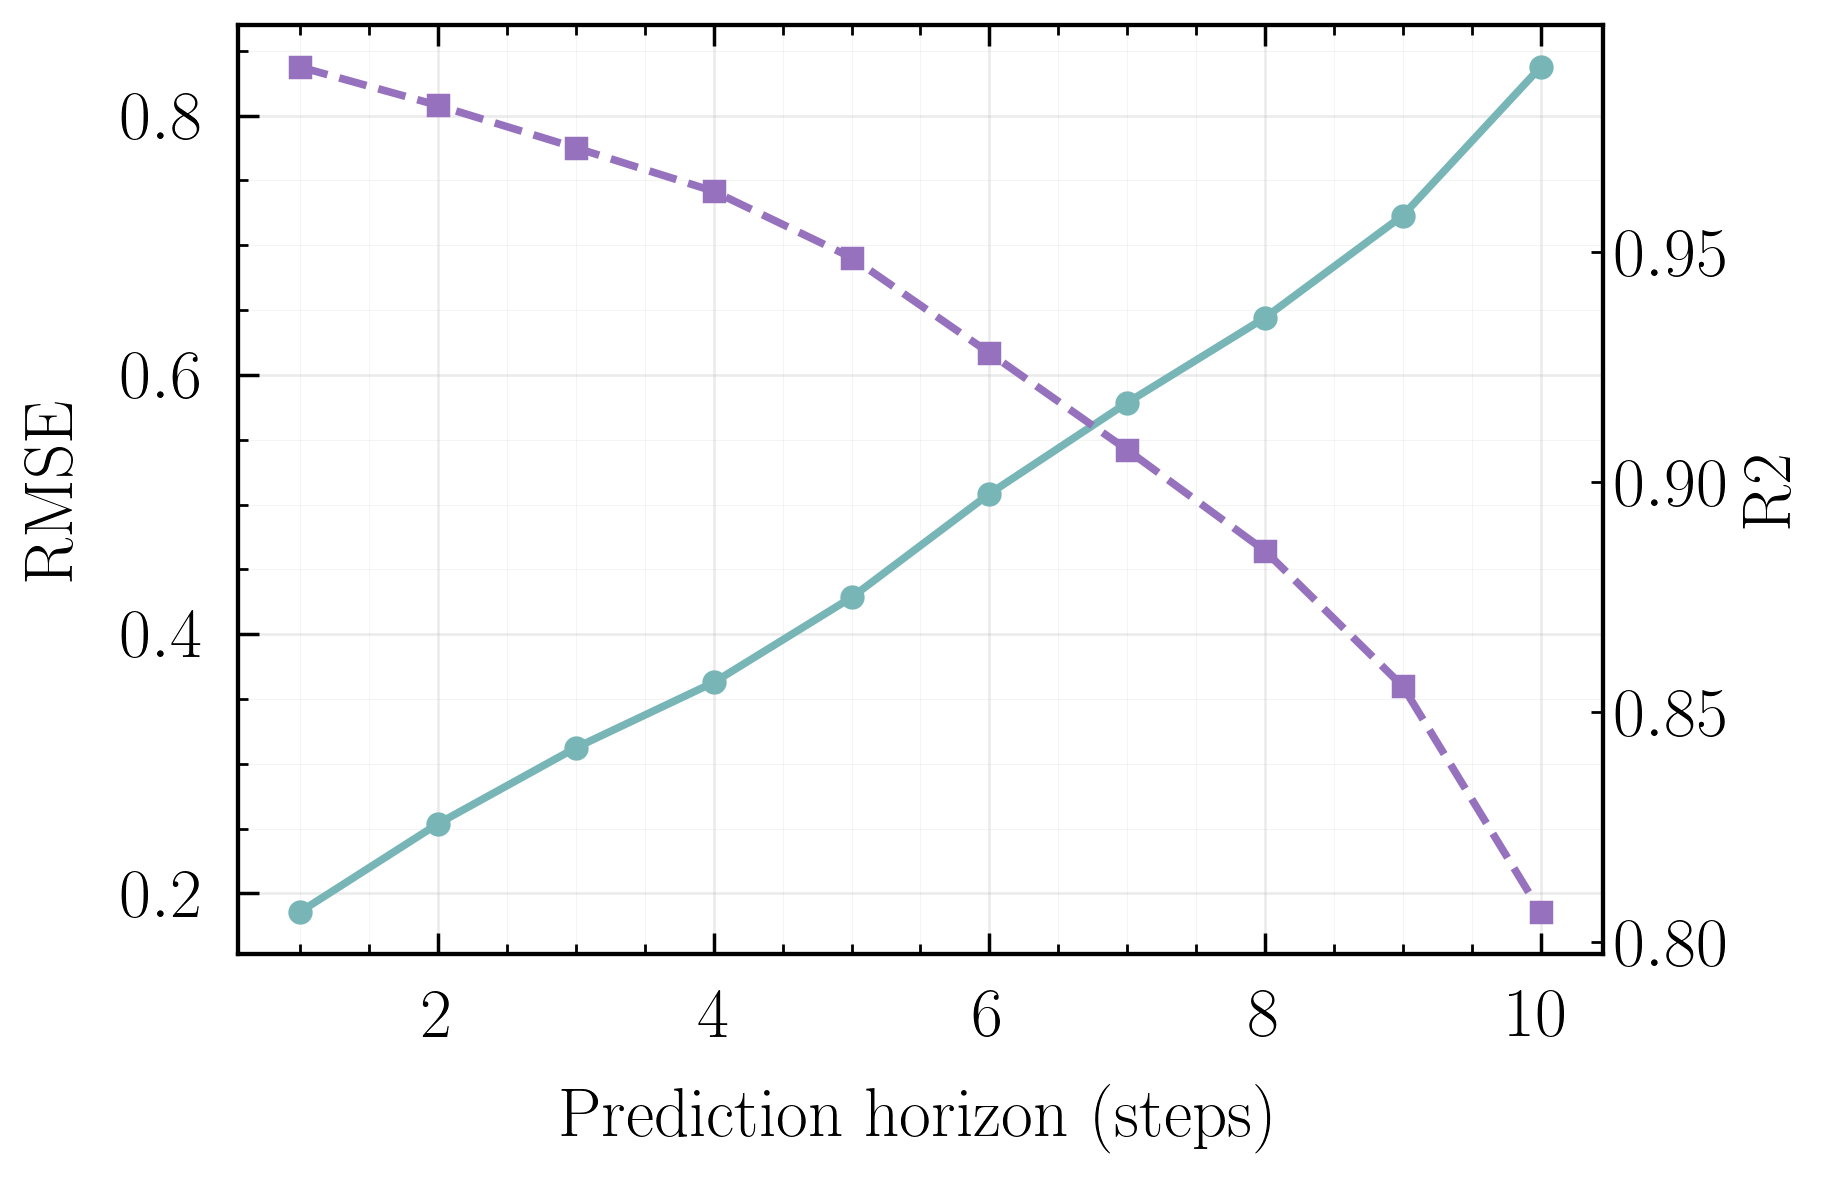

In [9]:
# Prediction window analysis (latent rollout)
PLOT_OUT_DIR = OUT_DIR / "plots"
PRED_WINDOW = CFG.get("PRED_WINDOW", None)
PRED_START = CFG.get("PRED_START_INDEX", None)

use_pred_files = "pred_files" in globals() and len(pred_files) > 0

if use_pred_files:
    t_pred_local = int(X_pred.shape[0])
    pred_start = int(PRED_START) if PRED_START is not None else 0
    if pred_start < 0 or pred_start >= t_pred_local:
        raise ValueError(
            f"PRED_START_INDEX must be in [0, {t_pred_local - 1}] when using prediction files."
        )
    if PRED_WINDOW is None:
        PRED_WINDOW = t_pred_local - pred_start
    PRED_WINDOW = int(PRED_WINDOW)
    available = t_pred_local - pred_start
    if PRED_WINDOW < 1:
        raise ValueError("PRED_WINDOW must be >= 1 when using prediction files.")
    actual_window = min(PRED_WINDOW, available)
    if actual_window < 1:
        raise ValueError(
            "Prediction window exceeds available prediction data after start index."
        )
    if actual_window < PRED_WINDOW and rank == 0:
        print(
            f"Clamping PRED_WINDOW to {actual_window} (available prediction snapshots)."
        )

    rmse_h = []
    r2_h = []
    model.eval()
    with torch.no_grad():
        z = model.encode(torch.from_numpy(Xn[-1]).unsqueeze(0).to(device))
        for _ in range(pred_start):
            z = model.step_latent(z)
        for h in range(1, actual_window + 1):
            idx = pred_start + h - 1
            if idx >= t_pred_local:
                break
            z = model.step_latent(z)
            pred = model.decode(z, out_hw=(H, W))[0].cpu().numpy()
            pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
            true = X_pred[idx]
            if torch.is_tensor(true):
                true = true.detach().cpu().numpy()
            err = pred_denorm - true
            rmse = float(np.sqrt(np.mean(err ** 2)))
            ss_res = float(np.sum(err ** 2))
            ss_tot = float(np.sum((true - true.mean()) ** 2))
            r2 = 1.0 - ss_res / (ss_tot + 1.0e-12)
            rmse_h.append(rmse)
            r2_h.append(r2)

    if rank == 0:
        import matplotlib.pyplot as plt
        horizons = np.arange(1, actual_window + 1)
        fig, ax1 = plt.subplots(figsize=(7.2, 4.6), dpi=FIG_DPI, constrained_layout=True)
        ax1.plot(horizons, rmse_h, "o-", label="RMSE", color=COLOR_DATA, linewidth=LINE_WIDTH)
        ax1.set_xlabel("Prediction horizon (steps)")
        ax1.set_ylabel("RMSE")
        style_axes(ax1)
        ax2 = ax1.twinx()
        ax2.plot(horizons, r2_h, "s--", color=COLOR_PRED, label="R2", linewidth=LINE_WIDTH)
        ax2.set_ylabel("R2")
        ax2.tick_params(axis="both", which="both", direction="in", top=True, right=True, labelsize=PLOT_FONT_SIZE)
        save_plot(fig, f"koopman_cnn_pred_window_rmse_r2_start{pred_start}_len{actual_window}", PLOT_OUT_DIR)
        plt.show()
else:
    if PRED_WINDOW is None:
        PRED_WINDOW = min(50, T - 1)
    PRED_WINDOW = int(PRED_WINDOW)
    if PRED_WINDOW < 1:
        raise ValueError("PRED_WINDOW must be >= 1.")

    if PRED_START is None:
        start_idx = max(0, T - 1 - PRED_WINDOW)
    else:
        start_idx = int(PRED_START)

    if start_idx < 0 or start_idx + PRED_WINDOW >= T:
        raise ValueError(
            f"Prediction window exceeds available data: start={start_idx}, "
            f"PRED_WINDOW={PRED_WINDOW}, T={T}."
        )

    rmse_h = []
    r2_h = []
    model.eval()
    with torch.no_grad():
        z = model.encode(torch.from_numpy(Xn[start_idx]).unsqueeze(0).to(device))
        for h in range(1, PRED_WINDOW + 1):
            z = model.step_latent(z)
            pred = model.decode(z, out_hw=(H, W))[0].cpu().numpy()
            pred_denorm = pred * X_std.squeeze(0) + X_mean.squeeze(0)
            true = X[start_idx + h]
            if torch.is_tensor(true):
                true = true.detach().cpu().numpy()
            err = pred_denorm - true
            rmse = float(np.sqrt(np.mean(err ** 2)))
            ss_res = float(np.sum(err ** 2))
            ss_tot = float(np.sum((true - true.mean()) ** 2))
            r2 = 1.0 - ss_res / (ss_tot + 1.0e-12)
            rmse_h.append(rmse)
            r2_h.append(r2)

    if rank == 0:
        import matplotlib.pyplot as plt
        horizons = np.arange(1, PRED_WINDOW + 1)
        fig, ax1 = plt.subplots(figsize=(7.2, 4.6), dpi=FIG_DPI, constrained_layout=True)
        ax1.plot(horizons, rmse_h, "o-", label="RMSE", color=COLOR_DATA, linewidth=LINE_WIDTH)
        ax1.set_xlabel("Prediction horizon (steps)")
        ax1.set_ylabel("RMSE")
        style_axes(ax1)
        ax2 = ax1.twinx()
        ax2.plot(horizons, r2_h, "s--", color=COLOR_PRED, label="R2", linewidth=LINE_WIDTH)
        ax2.set_ylabel("R2")
        ax2.tick_params(axis="both", which="both", direction="in", top=True, right=True, labelsize=PLOT_FONT_SIZE)
        save_plot(fig, f"koopman_cnn_pred_window_rmse_r2_start{start_idx}_len{PRED_WINDOW}", PLOT_OUT_DIR)
        plt.show()
